In [1]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

dask_wd = "/home/de64/scratch/de64/dask"
plt.style.use('./deaton.mplstyle')

## Load Functions

In [2]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

## Load Data

In [3]:
min_points = 5
pos_slope_thr = 0.2
neg_slope_thr = -0.2

ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/2024-01-25_lDE20_Steady_State_df_Estimators_wStats.pkl")
ss_estimators_df = ss_estimators_df.loc["Mean (Robust)"]
all_slopes_filtered = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Growth_Length_Slopes.csv",index_col="Gene")

In [4]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])

##hack to get both observatoins and proliferating observations (was broken)
observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])

variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])

ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
variance_estimators_df = np.sqrt(variance_estimators_df)
ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])

ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
ss_estimators_df = ss_estimators_df.join(final_column_df)
ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)

# ##removing controls
ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]

filtered_ss_estimators_df = ss_estimators_df[ss_estimators_df["Gene"].isin(all_slopes_filtered.index.tolist())]

In [5]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:00.796977  58,540 annotations READ: ./ecocyc.gaf 


## Figure S6A

Searching for tRNA aminoacylation for protein translation
Searching for ribosome
Searching for lipid metabolic process


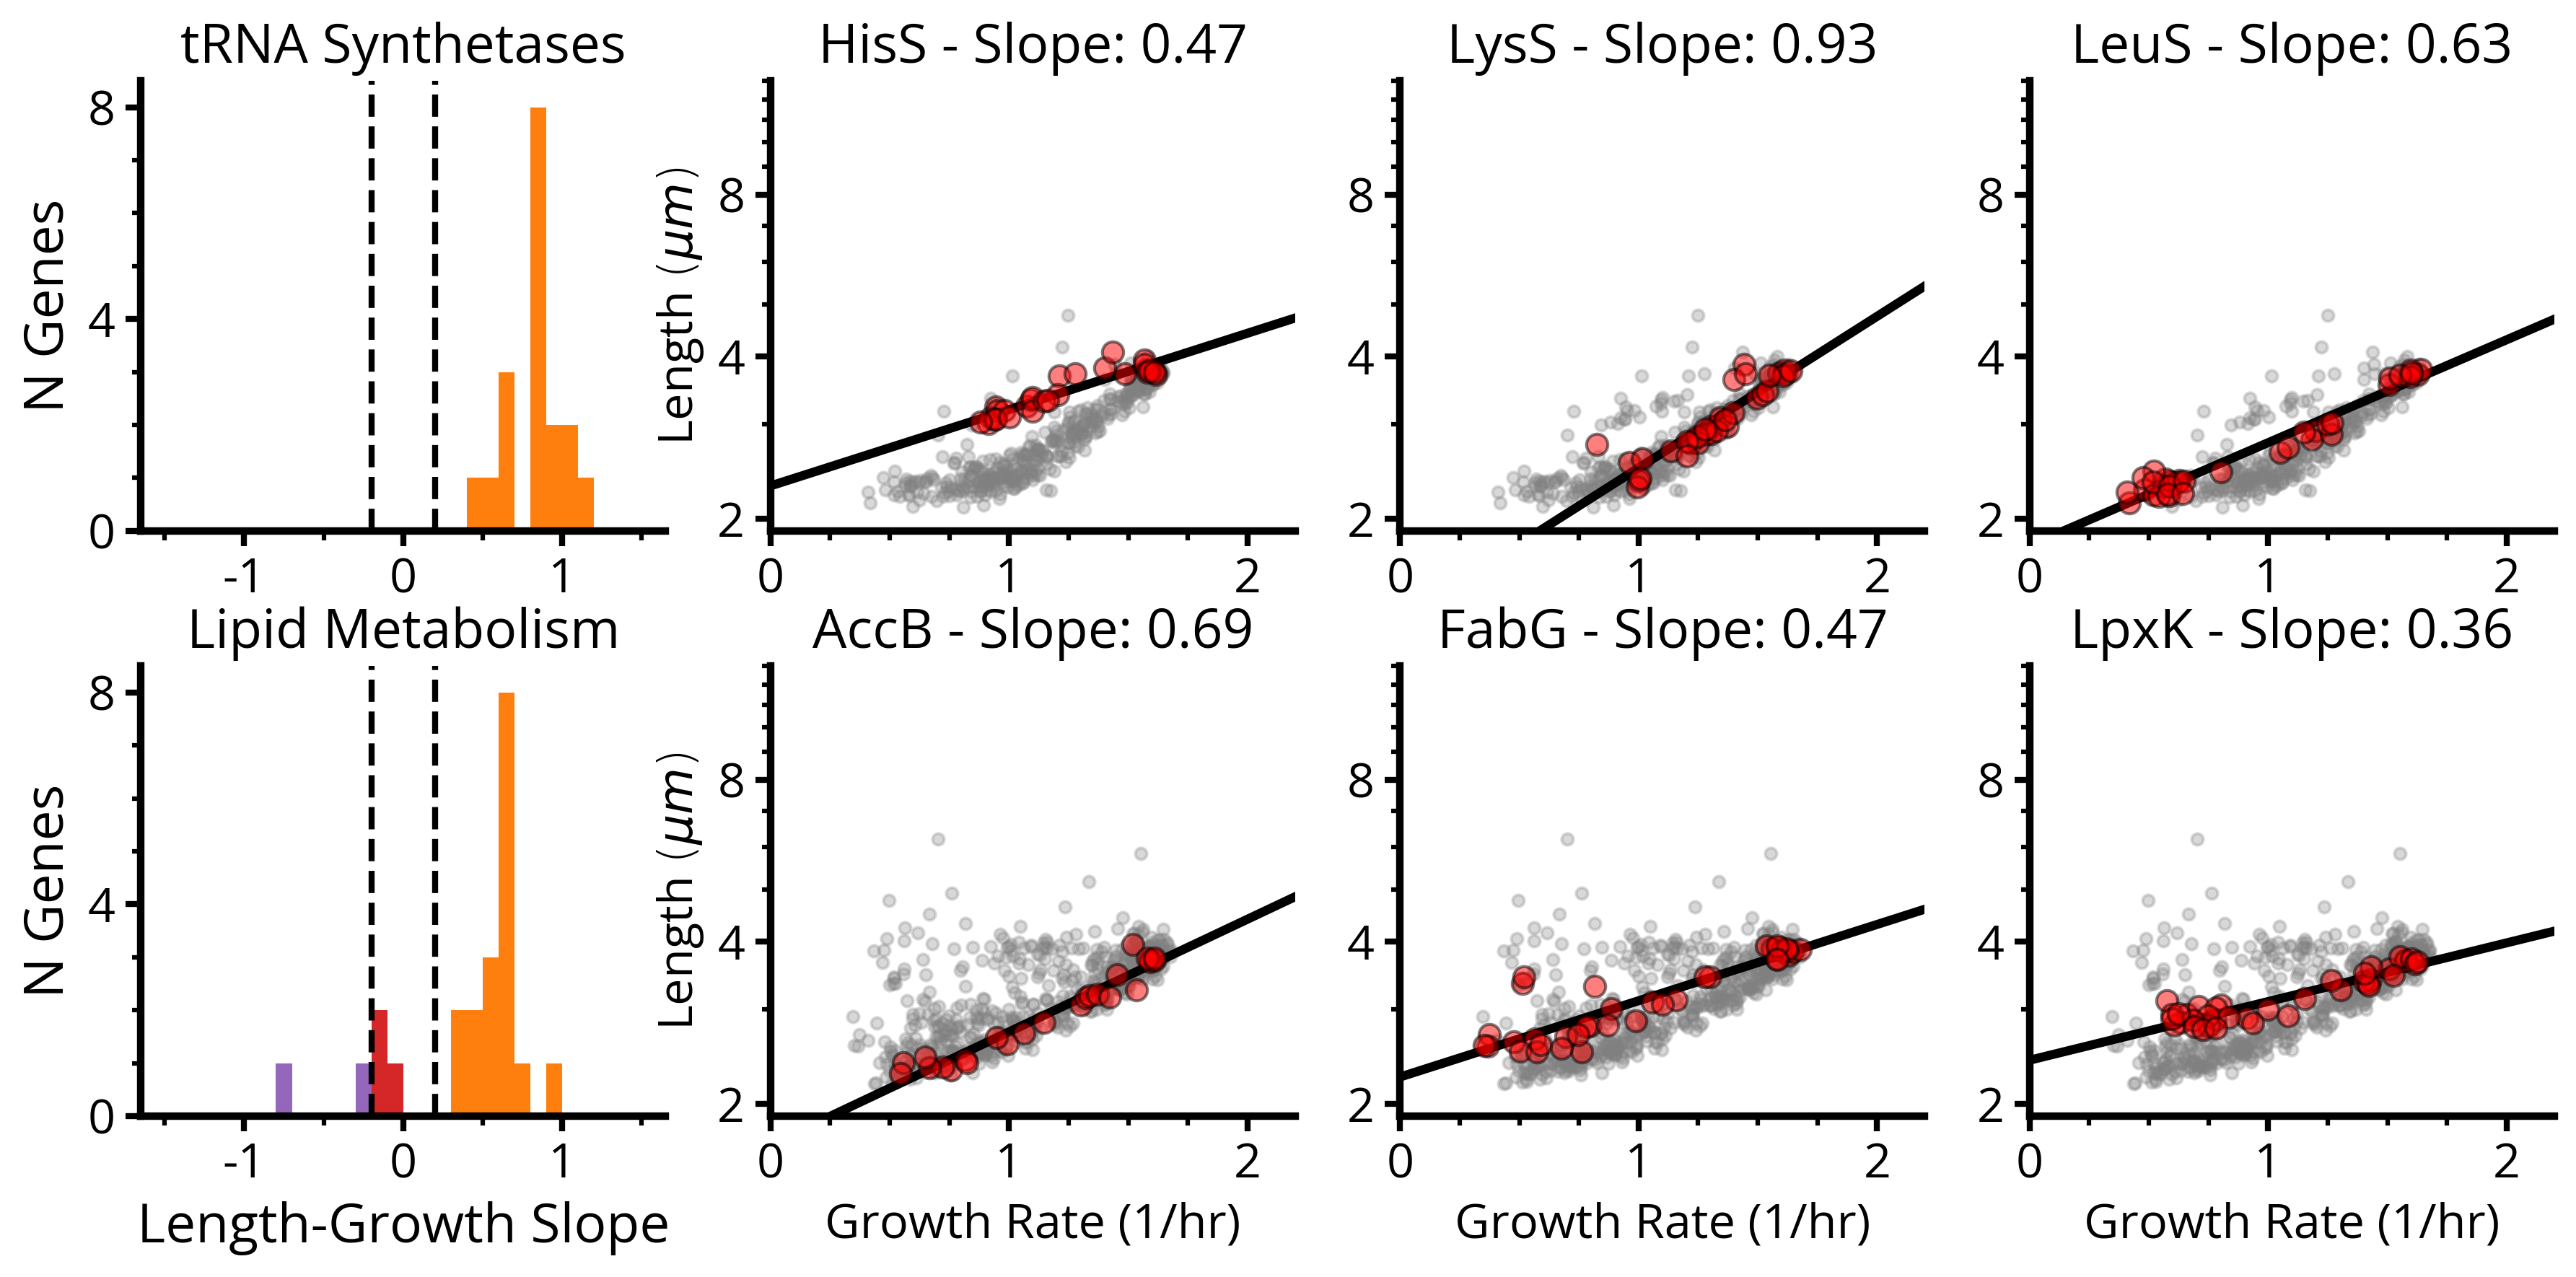

In [6]:
target_genes_list = ["tRNA Synthetases", "Lipid Metabolism"]
target_gene_subset_lists = [["hisS","lysS","leuS"],["accB","fabG","lpxK"]]
trna_synthetases_list = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006418")
all_ribosome = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0005840")
r_proteins_50S = [item for item in all_ribosome if ("rpl" in item)|("rpm" in item)]
r_proteins_30S = [item for item in all_ribosome if ("rps" in item)]
ribosome_biogenesis = ['der','obgE','rlmE','rluD',"era","ybeY","rimP","rsgA"]
termination = ["prfA","prfB","prmC"]
initiation = ["infA","infB"]
lipid_metabolic_process = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006629")
target_gene_lists = [trna_synthetases_list,lipid_metabolic_process]

fig,axes = plt.subplots(len(target_genes_list),4,figsize=(12,3*len(target_genes_list)))

for j,target_genes in enumerate(target_genes_list):
    target_gene_subset_list = target_gene_subset_lists[j]
    target_gene_list = target_gene_lists[j]

    target_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(target_gene_list)]
    
    ax = axes[j,0]
    
    ax.set_ylim(0,8.5)
    ax.set_title(target_genes,fontsize=18)
    ax.hist(target_slopes[target_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
    ax.hist(target_slopes[(target_slopes["Slope"]>neg_slope_thr)&\
                                 (target_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
    ax.hist(target_slopes[target_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
    ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

    if j == len(target_genes_list)-1:
        ax.set_xlabel("Length-Growth Slope",fontsize=18)
    else:
        ax.set_xlabel("",fontsize=18)
    ax.set_ylabel("N Genes",fontsize=18)
    ax.set_yticks(ticks=[0,4,8],labels=["0","4","8"],minor=False)
    ax.set_yticks(ticks=[1,2,3,5,6,7],labels=["","","","","",""],minor=True)
    ax.set_xticks(ticks=[-1,0,1],labels=["-1","0","1"],minor=False)
    ax.set_xticks(ticks=[-1.5,-0.5,0.5,1.5],labels=["","","",""],minor=True)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    sns.despine(right=True,top=True)

    for i in range(3):
        ax = axes[j,i+1]
        if i>=len(target_gene_subset_list):
            ax.axis("off")
        else:
            gene_name = target_gene_subset_list[i]
    
            genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
            selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
            selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
            selected_category_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"].isin(genes_in_category_wo_target)]
        
            xrange = np.linspace(0,2.2)
            ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-10,color="black")
            ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
            ax.scatter(selected_category_points["Instantaneous Growth Rate: Volume"],selected_category_points["Length"],\
                       edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
            if j == len(target_genes_list)-1:
                ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
            else:
                ax.set_xlabel("",fontsize=16)
            if i == 0:
                ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
            else:
                ax.set_ylabel("",fontsize=16)
            ax.set_xlim(0,2.2)
            ax.set_ylim(1.9,13)
            ax.set_yscale("log",base=2)
            ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
            ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
            ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
            ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
            ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
            ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
            ax.set_title(gene_name[0].capitalize() + gene_name[1:] + " - " + 'Slope: ' + str(np.round(selected_slope,decimals=2)),fontsize=18)
            sns.despine(right=True,top=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S6/Size_Scaling_Supplement_Small.png",transparent=True,dpi=300,bbox_inches="tight")

## Figure S6B

In [19]:
trna_synthetases_list = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006418")
all_ribosome = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0005840")
r_proteins_50S = [item for item in all_ribosome if ("rpl" in item)|("rpm" in item)]
r_proteins_30S = [item for item in all_ribosome if ("rps" in item)]
ribosome_biogenesis = ['der','obgE','rlmE','rluD',"era","ybeY","rimP","rsgA"]
termination = ["prfA","prfB","prmC"]
initiation = ["infA","infB"]
lipid_metabolic_process = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006629")

Searching for tRNA aminoacylation for protein translation
Searching for ribosome
Searching for lipid metabolic process


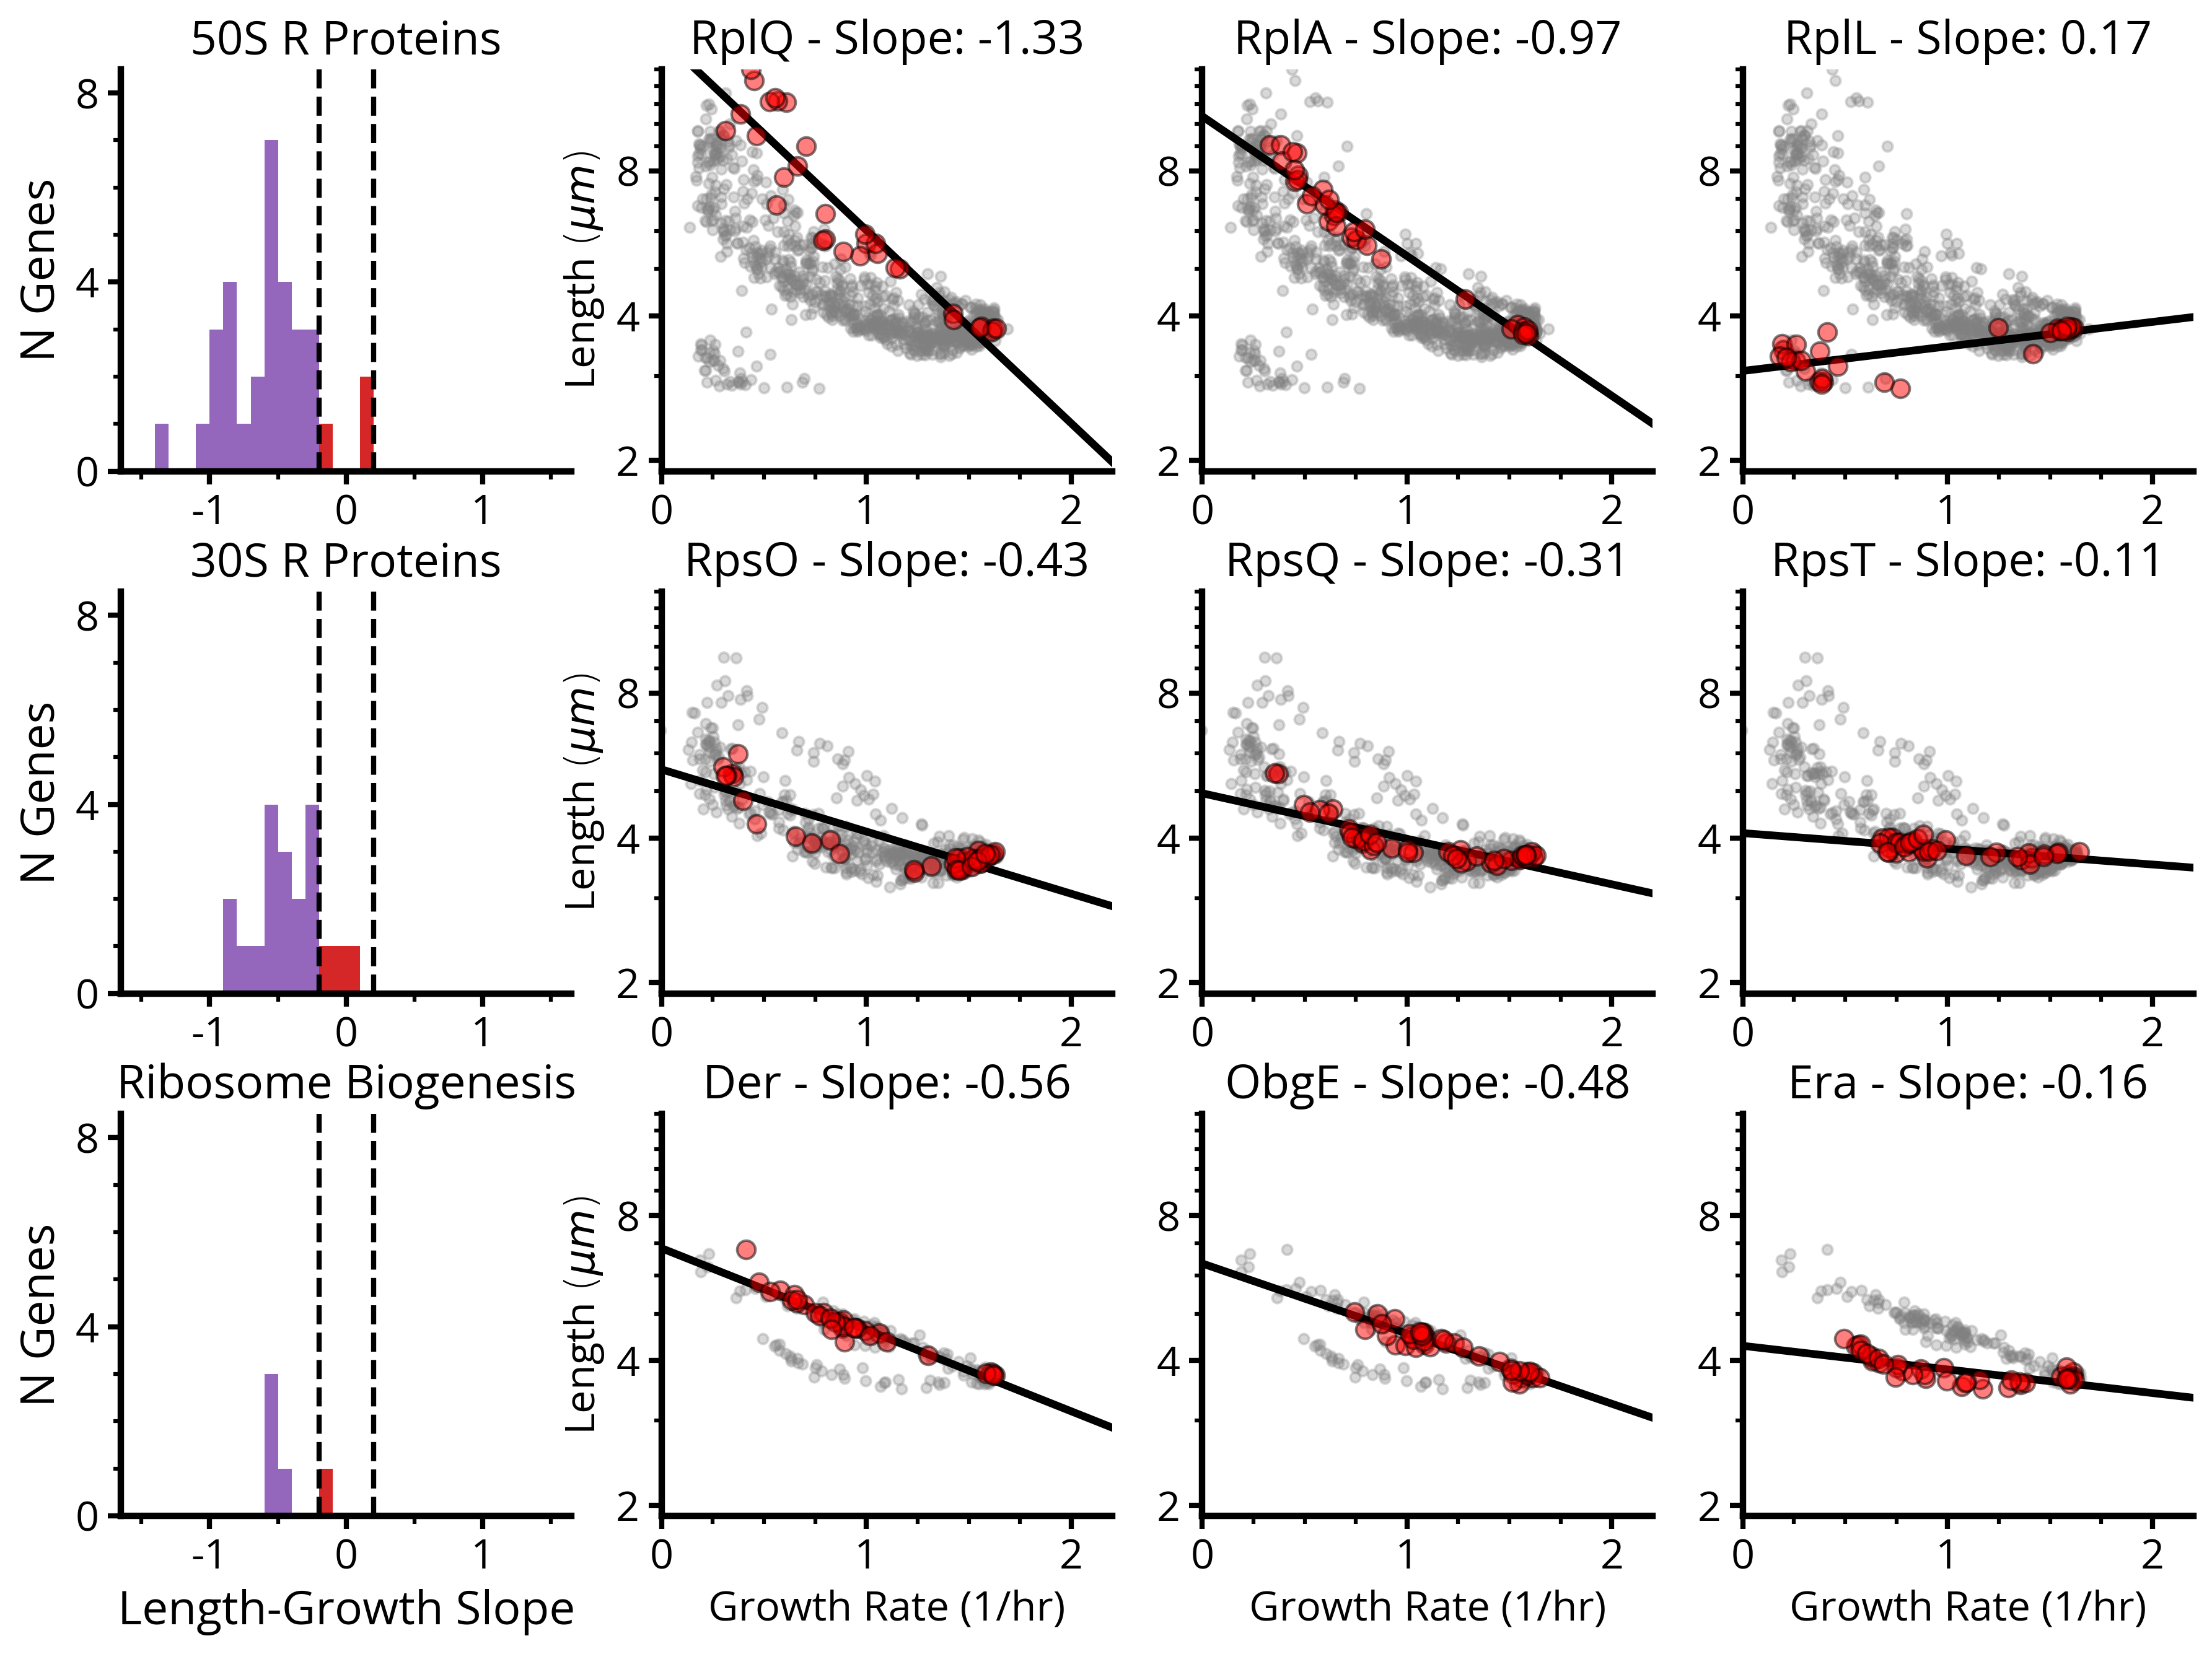

In [30]:
target_genes_list = ["50S R Proteins", "30S R Proteins", "Ribosome Biogenesis"]
target_gene_subset_lists = [["rplQ","rplA","rplL"],["rpsO","rpsQ","rpsT"],["der","obgE","era"]]
target_gene_lists = [r_proteins_50S,r_proteins_30S,ribosome_biogenesis]

fig,axes = plt.subplots(len(target_genes_list),4,figsize=(12,3*len(target_genes_list)))

for j,target_genes in enumerate(target_genes_list):
    target_gene_subset_list = target_gene_subset_lists[j]
    target_gene_list = target_gene_lists[j]

    target_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(target_gene_list)]
    
    ax = axes[j,0]
    
    ax.set_ylim(0,8.5)
    ax.set_title(target_genes,fontsize=18)
    ax.hist(target_slopes[target_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
    ax.hist(target_slopes[(target_slopes["Slope"]>neg_slope_thr)&\
                                 (target_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
    ax.hist(target_slopes[target_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
    ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

    if j == len(target_genes_list)-1:
        ax.set_xlabel("Length-Growth Slope",fontsize=18)
    else:
        ax.set_xlabel("",fontsize=18)
    ax.set_ylabel("N Genes",fontsize=18)
    ax.set_yticks(ticks=[0,4,8],labels=["0","4","8"],minor=False)
    ax.set_yticks(ticks=[1,2,3,5,6,7],labels=["","","","","",""],minor=True)
    ax.set_xticks(ticks=[-1,0,1],labels=["-1","0","1"],minor=False)
    ax.set_xticks(ticks=[-1.5,-0.5,0.5,1.5],labels=["","","",""],minor=True)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    sns.despine(right=True,top=True)

    for i in range(3):
        ax = axes[j,i+1]
        if i>=len(target_gene_subset_list):
            ax.axis("off")
        else:
            gene_name = target_gene_subset_list[i]
    
            genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
            selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
            selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
            selected_category_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"].isin(genes_in_category_wo_target)]
        
            xrange = np.linspace(0,2.2)
            ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-10,color="black")
            ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
            ax.scatter(selected_category_points["Instantaneous Growth Rate: Volume"],selected_category_points["Length"],\
                       edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
            if j == len(target_genes_list)-1:
                ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
            else:
                ax.set_xlabel("",fontsize=16)
            if i == 0:
                ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
            else:
                ax.set_ylabel("",fontsize=16)
            ax.set_xlim(0,2.2)
            ax.set_ylim(1.9,13)
            ax.set_yscale("log",base=2)
            ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
            ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
            ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
            ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
            ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
            ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
            ax.set_title(gene_name[0].capitalize() + gene_name[1:] + " - " + 'Slope: ' + str(np.round(selected_slope,decimals=2)),fontsize=18)
            sns.despine(right=True,top=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S6/Size_Scaling_Supplement_Ribosome.png",transparent=True,dpi=300,bbox_inches="tight")

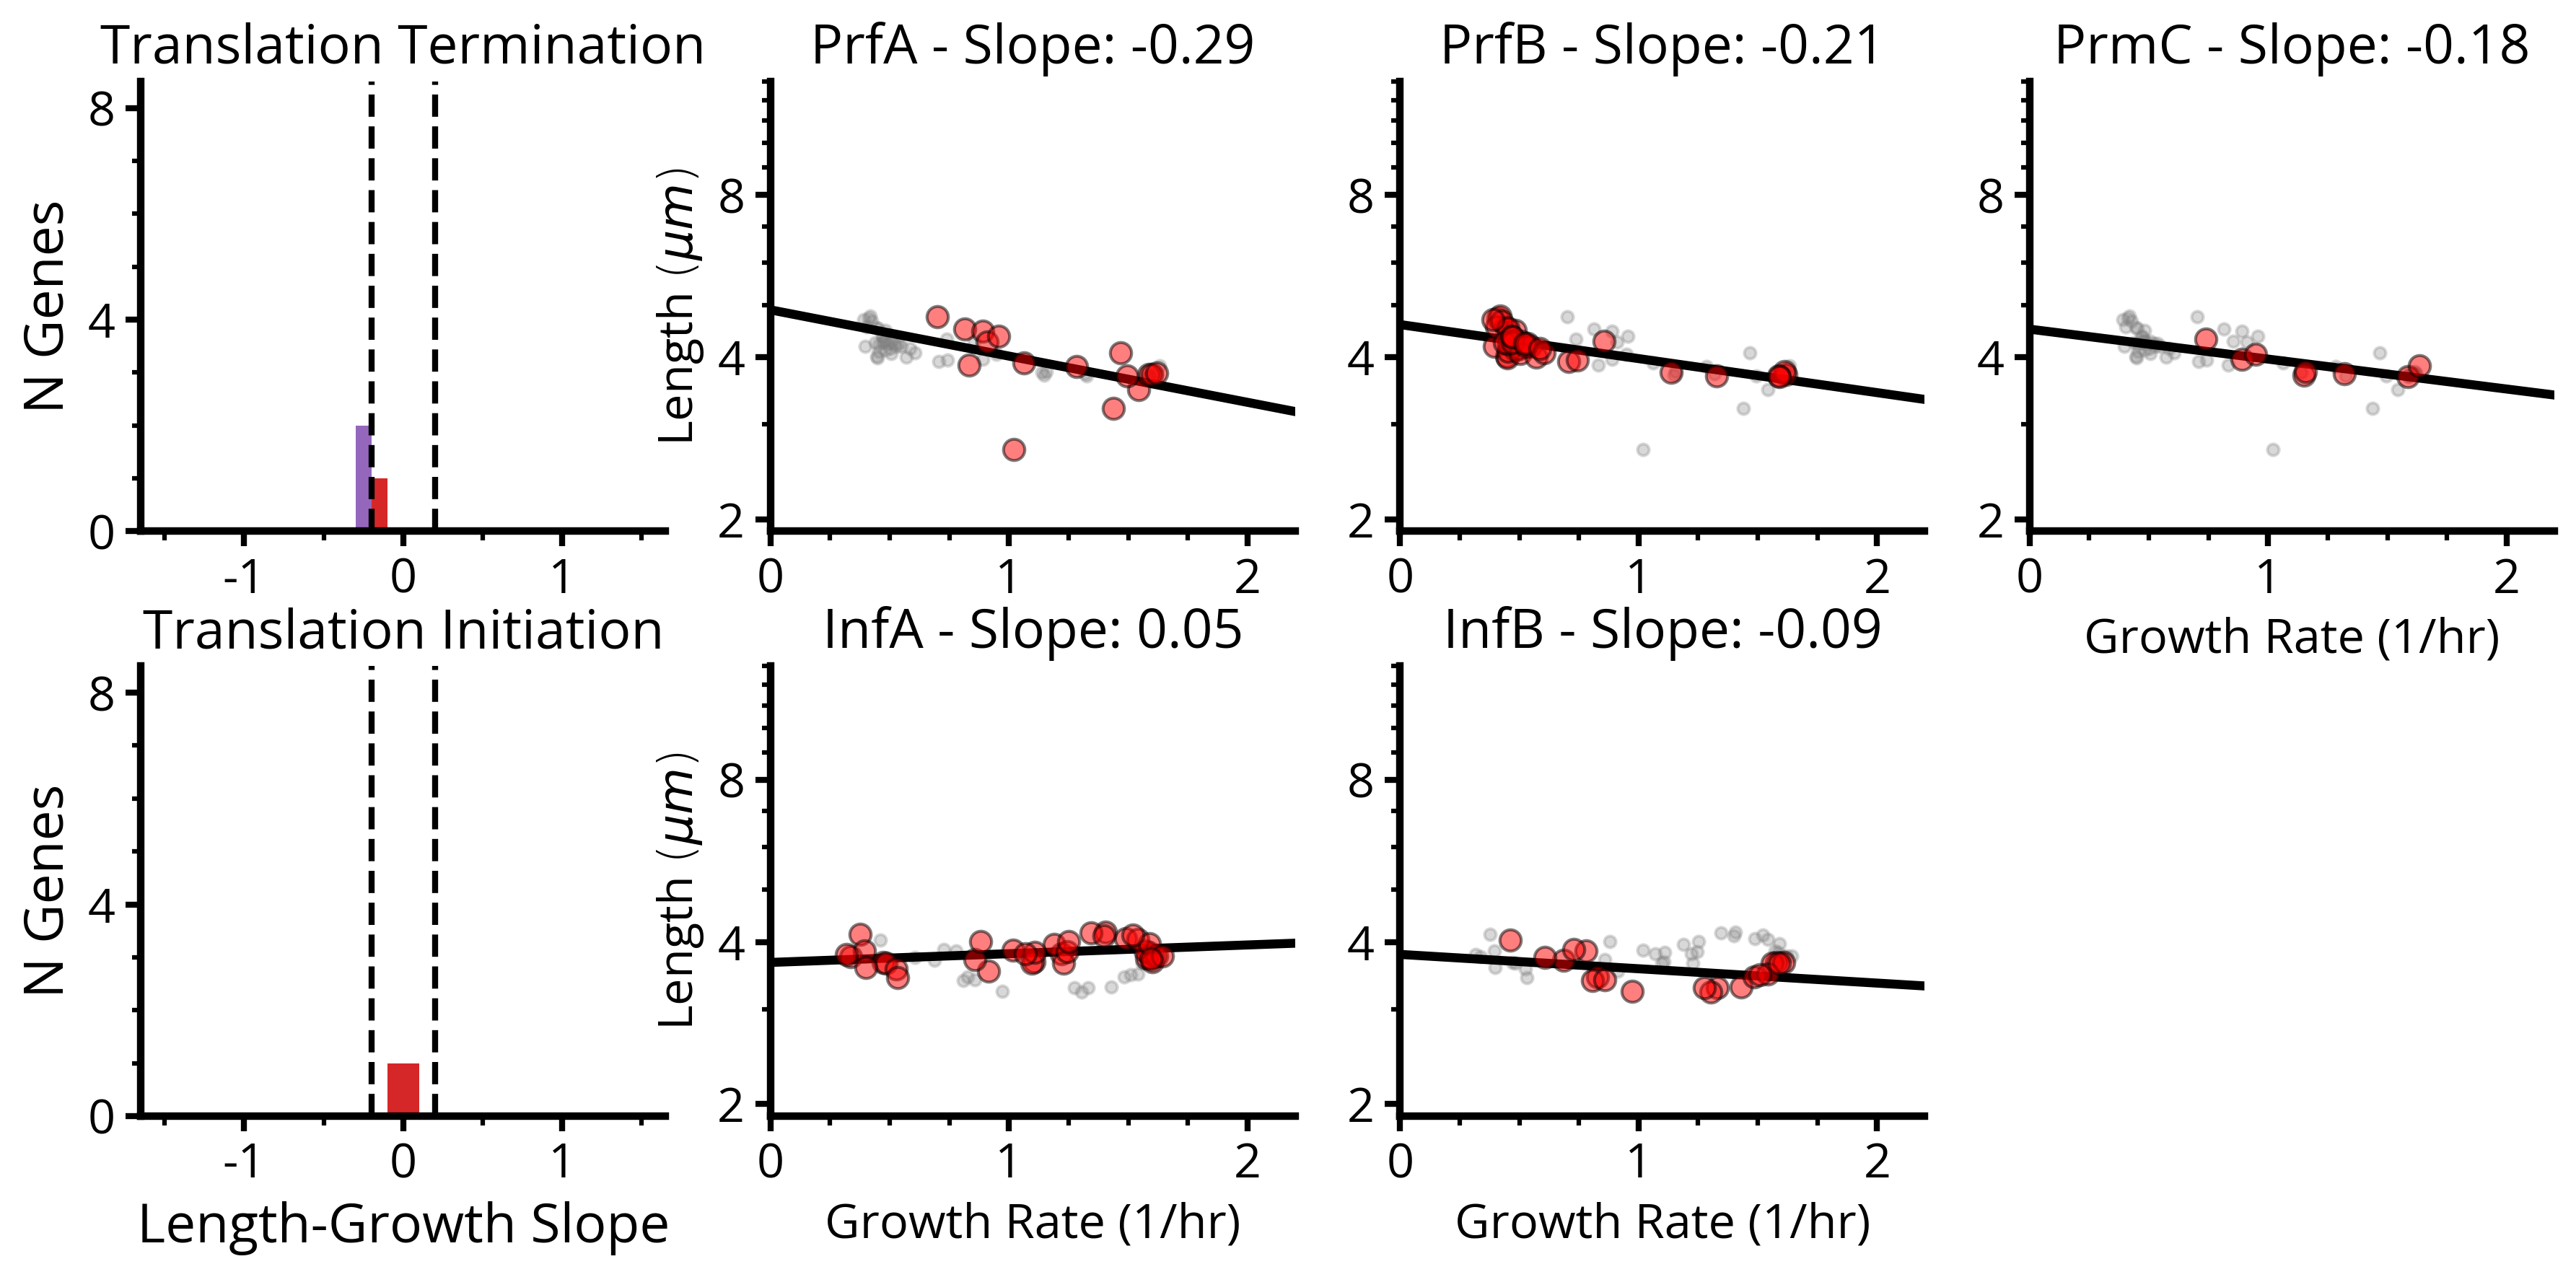

In [31]:
target_genes_list = ["Translation Termination","Translation Initiation"]
target_gene_subset_lists = [["prfA","prfB","prmC"],["infA","infB"]]
target_gene_lists = [termination,initiation]

fig,axes = plt.subplots(len(target_genes_list),4,figsize=(12,3*len(target_genes_list)))

for j,target_genes in enumerate(target_genes_list):
    target_gene_subset_list = target_gene_subset_lists[j]
    target_gene_list = target_gene_lists[j]

    target_slopes = all_slopes_filtered[all_slopes_filtered.index.isin(target_gene_list)]
    
    ax = axes[j,0]
    
    ax.set_ylim(0,8.5)
    ax.set_title(target_genes,fontsize=18)
    ax.hist(target_slopes[target_slopes["Slope"]<=neg_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:purple")
    ax.hist(target_slopes[(target_slopes["Slope"]>neg_slope_thr)&\
                                 (target_slopes["Slope"]<pos_slope_thr)]["Slope"],range=(-1.5,1.5),bins=30,color="tab:red")
    ax.hist(target_slopes[target_slopes["Slope"]>=pos_slope_thr]["Slope"],range=(-1.5,1.5),bins=30,color="tab:orange")
    ax.vlines([neg_slope_thr,pos_slope_thr],ax.get_ylim()[0],ax.get_ylim()[1],linestyle="--",linewidth=2,color="black")

    if j == len(target_genes_list)-1:
        ax.set_xlabel("Length-Growth Slope",fontsize=18)
    else:
        ax.set_xlabel("",fontsize=18)
    ax.set_ylabel("N Genes",fontsize=18)
    ax.set_yticks(ticks=[0,4,8],labels=["0","4","8"],minor=False)
    ax.set_yticks(ticks=[1,2,3,5,6,7],labels=["","","","","",""],minor=True)
    ax.set_xticks(ticks=[-1,0,1],labels=["-1","0","1"],minor=False)
    ax.set_xticks(ticks=[-1.5,-0.5,0.5,1.5],labels=["","","",""],minor=True)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
    ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
    ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
    ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
    sns.despine(right=True,top=True)

    for i in range(3):
        ax = axes[j,i+1]
        if i>=len(target_gene_subset_list):
            ax.axis("off")
        else:
            gene_name = target_gene_subset_list[i]
    
            genes_in_category_wo_target = list(set(target_gene_list)-set([gene_name]))
            selected_slope,selected_intercept = all_slopes_filtered.loc[gene_name]["Slope"],all_slopes_filtered.loc[gene_name]["Intercept"]
            selected_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"] == gene_name]
            selected_category_points = filtered_ss_estimators_df[filtered_ss_estimators_df["Gene"].isin(genes_in_category_wo_target)]
        
            xrange = np.linspace(0,2.2)
            ax.plot(xrange, 2**(xrange*selected_slope + selected_intercept),linewidth=3,zorder=-10,color="black")
            ax.scatter(selected_points["Instantaneous Growth Rate: Volume"],selected_points["Length"],edgecolors='black',alpha=0.5,\
                       s=50,zorder=-9,color="red")
            ax.scatter(selected_category_points["Instantaneous Growth Rate: Volume"],selected_category_points["Length"],\
                       edgecolors=None,alpha=0.3,s=15,zorder=-11,color="grey")
            if j == len(target_genes_list)-1:
                ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
            elif (j==0) & (i==2):
                ax.set_xlabel("Growth Rate (1/hr)",fontsize=16)
            else:
                ax.set_xlabel("",fontsize=16)
            if i == 0:
                ax.set_ylabel("Length $ (\mu m) $",fontsize=16)
            else:
                ax.set_ylabel("",fontsize=16)
            ax.set_xlim(0,2.2)
            ax.set_ylim(1.9,13)
            ax.set_yscale("log",base=2)
            ax.set_yticks(ticks=[2,4,8],labels=["2","4","8"],fontsize=16,minor=False)
            ax.set_xticks(ticks=[0,1.,2.],labels=["0","1","2"],minor=False)
            ax.set_yticks(ticks=[3,5,6,7,9,10,11,12,13],labels=[],minor=True)
            ax.set_xticks(ticks=[0.25,0.5,0.75,1.25,1.5,1.75],labels=[],minor=True)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=2, length=5)
            ax.tick_params(axis='both', direction='out', labelsize=16,  width=1.5, which='minor', length=3)
            ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
            ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
            ax.set_title(gene_name[0].capitalize() + gene_name[1:] + " - " + 'Slope: ' + str(np.round(selected_slope,decimals=2)),fontsize=18)
            sns.despine(right=True,top=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S6/Size_Scaling_Supplement_Translation.png",transparent=True,dpi=300,bbox_inches="tight")